<a href="https://colab.research.google.com/github/SophiaHe/covid19_work/blob/master/ImportCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import WHO Daily Covid-19 Data

In [21]:
!pip install wget
import pandas as pd
import wget

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for url in urls:
    filename = wget.download(url)

conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

dates = conf_df.columns[4:]
dates2 = recv_df.columns[4:]

conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates2, var_name='Date', value_name='Recovered')
recv_df_long['Date'] = recv_df_long['Date'].str[:-2]

full_table = pd.concat([conf_df_long, deaths_df_long['Deaths'], recv_df_long['Recovered']], axis=1, sort=False)

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0.0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0.0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0.0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0.0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0.0


In [0]:
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]
full_table.to_csv('covid_19_clean_complete.csv', index=False)

Web Scrapping For Ontario Patient Details

In [0]:
!pip install requests
!pip install beautifulsoup4

In [0]:
import requests
from bs4 import BeautifulSoup

In [0]:
url = "https://www.ontario.ca/page/2019-novel-coronavirus"
page = requests.get(url)

In [0]:
print(page.status_code) 

200


In [0]:
print(page.content)

b'<!doctype html> <html class="no-js" lang="en"> <head> <meta charset="utf-8"> <meta name="viewport" content="width=device-width,initial-scale=1"> <meta http-equiv="X-UA-Compatible" content="IE=edge"> <meta name="sha" content="2488e70214b0dfd8a40df37427e9633c8f527b3d"> <title></title> <base href="/"> <link rel="stylesheet" media="screen" href="/css/combined.css"> <link rel="stylesheet" media="print" href="/css/print.css"> <script src="/vendor/modernizr/modernizr.js"></script> <script>!function(a,e,o,n,c,i,t){a.GoogleAnalyticsObject=c,a.ga=a.ga||function(){(a.ga.q=a.ga.q||[]).push(arguments)},a.ga.l=1*new Date,i=e.createElement(o),t=e.getElementsByTagName(o)[0],i.async=1,i.src="//www.google-analytics.com/analytics.js",t.parentNode.insertBefore(i,t)}(window,document,"script",0,"ga"),ga("create","UA-21003310-6",{cookieDomain:"auto",allowLinker:!0}),ga("create","UA-48649528-1",{cookieDomain:"auto",allowLinker:!0,name:"ServiceOntario"}),ga("require","linker"),ga("linker:autoLink",["serviceo

      fun: 1.9735072467227621
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.10661932e+01, 7.47726325e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 16
   status: 0
  success: True
        x: array([4.99003307e-06, 1.97963899e-03])
country=US, beta=0.00000499, gamma=0.00197964, r_0:0.00252068


,Confirmed,Recovered,S,I,R
1/22/20,1,0,15000.000000,2.000000,0.000000
1/23/20,1,0,14999.844710,2.151182,0.004107
1/24/20,1,0,14999.677673,2.313802,0.008525
1/25/20,1,0,14999.498012,2.488711,0.013277
1/26/20,1,0,14999.304785,2.676828,0.018387
...,...,...,...,...,...
06/15/20,None,None,2451.958419,11832.634834,717.406746
06/16/20,None,None,2310.688499,11950.360886,740.950615
06/17/20,None,None,2176.412502,12060.864778,764.722720
06/18/20,None,None,2048.912631,12164.379453,788.707917


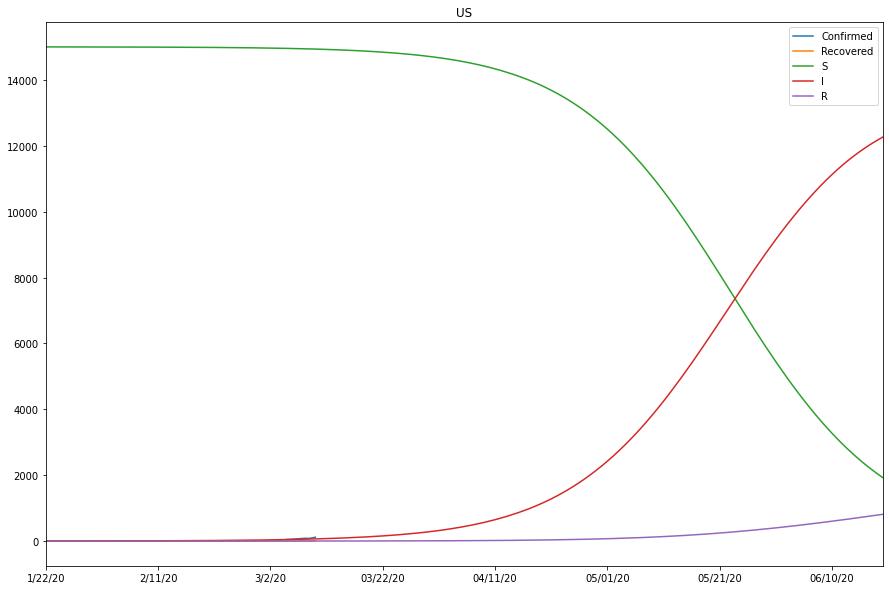

In [0]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

S_0 = 15000
I_0 = 2
R_0 = 0

START_DATE = {
  'Japan': '1/22/20',
  'Italy': '1/31/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20',
  'Mainland China': '1/22/20',
  'Canada': '1/22/20',
  'US': '1/22/20'
}

class Learner(object):
    def __init__(self, country, loss):
        self.country = country
        self.loss = loss

    def load_confirmed(self, country):
      df = pd.read_csv('https://raw.githubusercontent.com/Lewuathe/COVID19-SIR/master/data/time_series_19-covid-Confirmed.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def load_recovered(self, country):
      df = pd.read_csv('https://raw.githubusercontent.com/Lewuathe/COVID19-SIR/master/data/time_series_19-covid-Recovered.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, country):
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        data = self.load_confirmed(self.country)
        recovered = self.load_recovered(self.country)
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, prediction = self.predict(beta, gamma, data, recovered, self.country)
        df = pd.DataFrame({'Confirmed': extended_actual, 'Recovered': extended_recovered, 'S': prediction.y[0], 'I': prediction.y[1], 'R': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")
        return df

def loss(point, data, recovered):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

learner = Learner('US', loss)
learner.train()


      fun: 87.7971892496024
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([809663.12364268,   3085.88376896])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 180
      nit: 4
   status: 2
  success: False
        x: array([1.29776738e-05, 1.00000000e-08])
country=Republic of Korea, beta=0.00001298, gamma=0.00000001, r_0:1297.76738286


,Confirmed,Recovered,S,I,R
1/22/20,1,0,15000.000000,2.000000,0.000000e+00
1/23/20,1,0,14999.570198,2.429802,2.207938e-08
1/24/20,2,0,14999.047998,2.952002,4.890619e-08
1/25/20,2,0,14998.413404,3.586596,8.150842e-08
1/26/20,3,0,14997.643233,4.356767,1.210776e-07
...,...,...,...,...,...
06/15/20,None,None,0.000063,15001.985058,1.487914e-02
06/16/20,None,None,0.000052,15001.984919,1.502916e-02
06/17/20,None,None,0.000043,15001.984778,1.517918e-02
06/18/20,None,None,0.000035,15001.984636,1.532920e-02


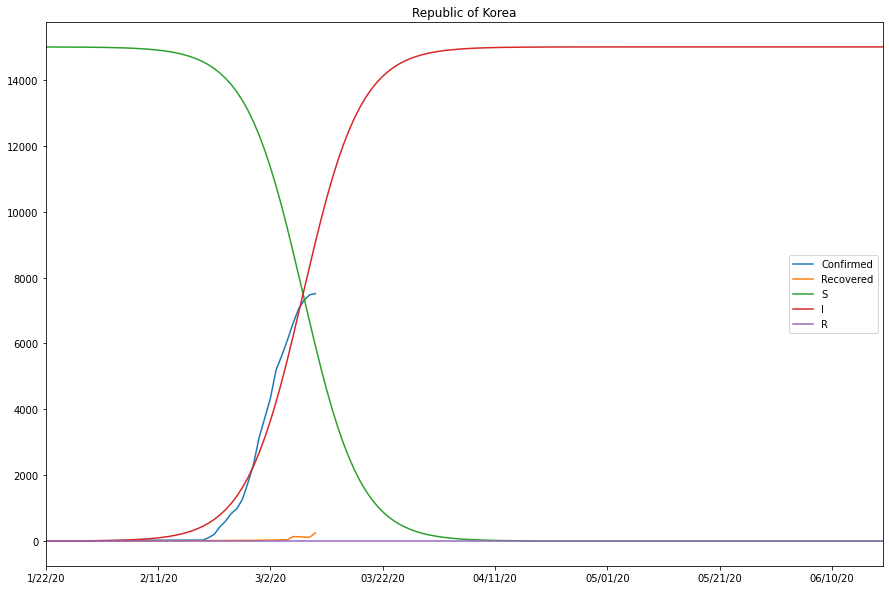

In [0]:
learner = Learner('Republic of Korea', loss)
learner.train()


In [0]:
learner = Learner('Italy', loss)
learner.train()
learner = Learner('Iran (Islamic Republic of)', loss)
learner.train()